# Correspondence Evaluation Analysis
This notebook analyzes recall metrics for different DINOv2 model checkpoints evaluated on the NAVI_wild_all dataset.


=== Pearson Correlation Matrix for vitb14_long ===
            knn_top1  knn_top5  recall_vp0  recall_vp1  recall_vp2  recall_all
knn_top1    1.000000  0.993158    0.959712    0.952757    0.939824    0.954139
knn_top5    0.993158  1.000000    0.921134    0.912028    0.893924    0.913156
recall_vp0  0.959712  0.921134    1.000000    0.999437    0.995124    0.999475
recall_vp1  0.952757  0.912028    0.999437    1.000000    0.995153    0.999235
recall_vp2  0.939824  0.893924    0.995124    0.995153    1.000000    0.997407
recall_all  0.954139  0.913156    0.999475    0.999235    0.997407    1.000000


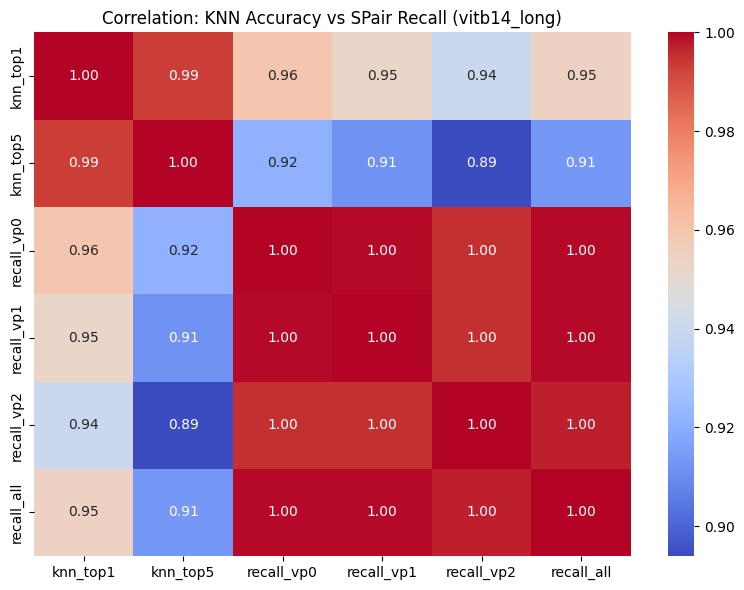


=== Pearson Correlation Matrix for vitb14_reg ===
            knn_top1  knn_top5  recall_vp0  recall_vp1  recall_vp2  recall_all
knn_top1    1.000000  0.994483    0.968570    0.976321    0.956595    0.963598
knn_top5    0.994483  1.000000    0.938158    0.949069    0.921329    0.930935
recall_vp0  0.968570  0.938158    1.000000    0.998615    0.997055    0.999516
recall_vp1  0.976321  0.949069    0.998615    1.000000    0.994977    0.998151
recall_vp2  0.956595  0.921329    0.997055    0.994977    1.000000    0.998312
recall_all  0.963598  0.930935    0.999516    0.998151    0.998312    1.000000


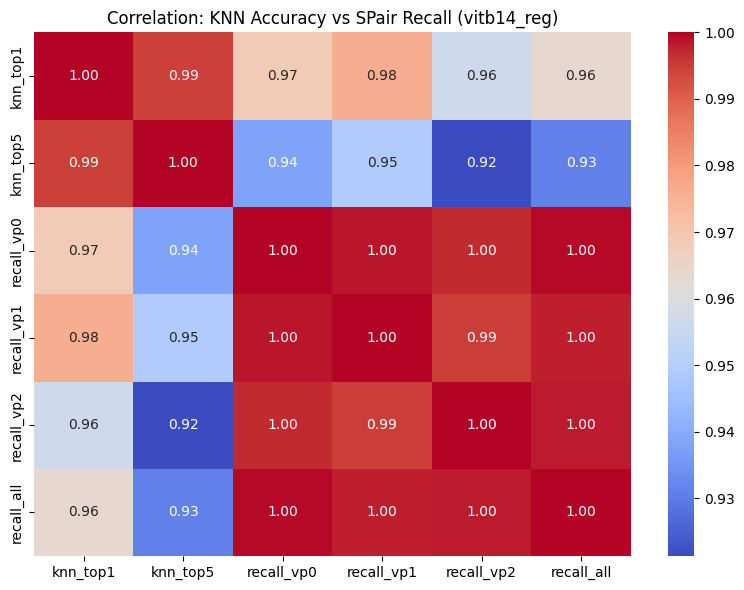

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
KNN_DIRS = {
    'vitb14_long': "/work/dlclarge2/sunagadb-runs/dinov2/outputs_b14_long/eval",
    'vitb14_reg': "/work/dlclarge2/sunagadb-runs/dinov2/outputs_b14/eval"
}
SPAIR_LOG_FILE = "spair_correspondence.log"
TARGET_K = 20  # for k-NN accuracy

# === STEP 1: Load KNN Accuracy from Logs ===
knn_records = []

for model_type, base_dir in KNN_DIRS.items():
    for entry in os.listdir(base_dir):
        match = re.match(r'training_(\d+)', entry)
        if match:
            iteration = int(match.group(1))
            log_path = os.path.join(base_dir, entry, "knn", "logs", "log.txt")

            if os.path.exists(log_path):
                with open(log_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if f"('full', {TARGET_K}) classifier result" in line:
                            top1 = float(re.search(r'Top1: ([0-9.]+)', line).group(1))
                            top5 = float(re.search(r'Top5: ([0-9.]+)', line).group(1))
                            knn_records.append({
                                'step': iteration,
                                'knn_top1': top1,
                                'knn_top5': top5,
                                'model_type': model_type
                            })
                            break

# Create KNN DataFrame
df_knn = pd.DataFrame(knn_records)

# === STEP 2: Load SPair Correspondence Log ===
columns = [
    'timestamp', 'model', 'patch_size', 'layer', 'output_type', 'dataset', 
    'split', 'eval_class', 'num_instances',
    'recall_vp0', 'recall_vp1', 'recall_vp2', 'recall_all'
]

df_spair = pd.read_csv(SPAIR_LOG_FILE, header=None, names=columns)
df_spair['step'] = df_spair['model'].str.extract(r'-(\d+)-')[0].astype(float)

# Filter to only include the two model types
df_spair = df_spair[df_spair['model'].str.contains('dinov2_vitb14_reg-outputs_b14|dinov2_vitb14-outputs_b14_long')].copy()

# Label model type
df_spair['model_type'] = df_spair['model'].apply(
    lambda x: 'vitb14_reg' if 'reg' in x else 'vitb14_long'
)

# === STEP 3: Merge KNN and SPair on (step, model_type) ===
df_merged = pd.merge(df_knn, df_spair, on=['step', 'model_type'])

# === STEP 4: Compute and Visualize Correlation ===
correlation_df = df_merged[['model_type', 'knn_top1', 'knn_top5', 'recall_vp0', 'recall_vp1', 'recall_vp2', 'recall_all']]

# Compute correlations separately for each model
for model in correlation_df['model_type'].unique():
    print(f"\n=== Pearson Correlation Matrix for {model} ===")
    subset = correlation_df[correlation_df['model_type'] == model]
    corr_matrix = subset.drop(columns='model_type').corr(method='pearson')
    print(corr_matrix)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Correlation: KNN Accuracy vs SPair Recall ({model})")
    plt.tight_layout()
    plt.show()
